# Louis Long Notebook

### Emil studid & Louis studid, teamname 

#### Table of contents:
1. Exploratory data analysis
2. Models/Predictors
    - Model 1
    - Model 2
    - model ...
3. Model Interpretations
    - Lime
    - feature importance
    - PDP
4. Feature Engineering
5. Improved models (possibly)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from pandas_profiling import ProfileReport

# 1. Exploratory Data Analysis


### EDA Notes
- [ ] Search domain knowledge
- [ ] Check if the data is intuitive
- [ ] Understand how the data was generated
- [ ] Explore individual features
    - [x] Agencies
    - [x] stores with 0 revenue
    - [x] food and drink stores and grovery stores
- [ ] Explore pairs and groups
    - [x] Store type vs revenue
- [ ] Clean up features
    - [ ] remove 2016
    - [ ] remove outliers
    - [ ] remove 0 revenue rows


In [2]:
stores_train = pd.read_csv('data/stores_train.csv')


In [3]:
stores_train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


In [4]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [5]:
stores_train.describe()

,year,grunnkrets_id,lat,lon,revenue
count,12859.0,1.285900e+04,12859.000000,12859.000000,12859.000000
mean,2016.0,9.338697e+06,61.212166,9.995425,8.220683
std,0.0,5.788875e+06,2.965672,3.793565,15.377130
min,2016.0,1.010105e+06,57.994443,4.625889,0.000000
25%,2016.0,3.014208e+06,59.421935,7.284691,1.195000
50%,2016.0,9.065213e+06,59.939017,10.407916,3.374000
75%,2016.0,1.449011e+07,62.116531,10.848180,7.996000
max,2016.0,2.030031e+07,71.098287,31.118935,219.599000


In [6]:
#report = ProfileReport(stores_train)
#report

Explore revenue based on store type

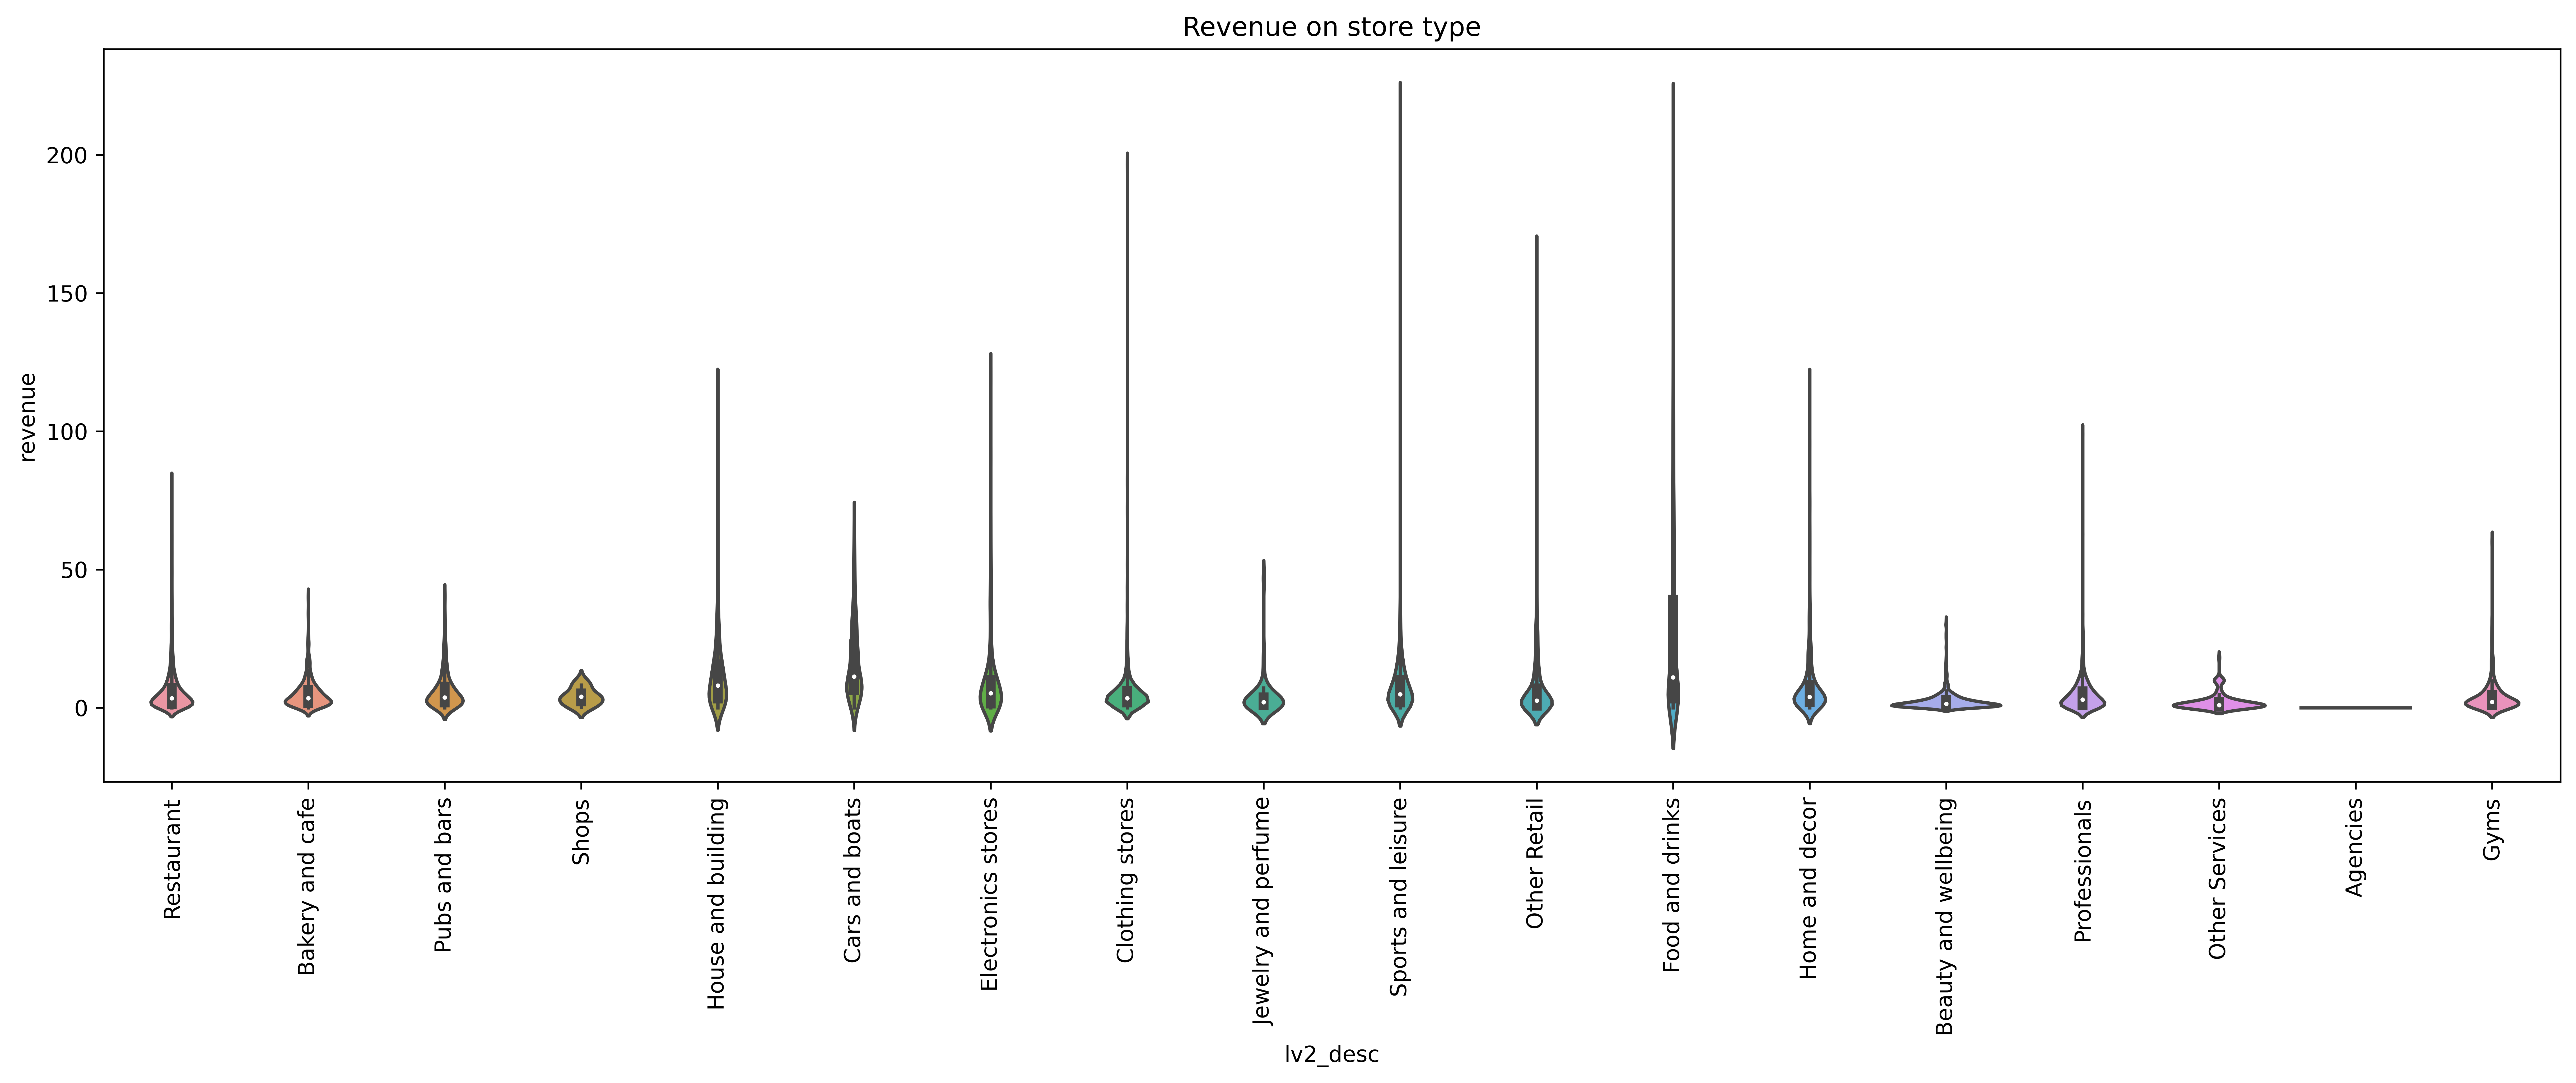

In [7]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [9]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
12442,915797512-915815782-782390,2016,RUUKKI BUILDING COMPONENTS AS,3.5.3.0,Advertising agencies,3014005,ØSTRE AKER VEI 219,59.948112,10.883745,NaN,...,0.0,Advertising agencies,3,Services,3.5,Agencies,3.5.3,Advertising agencies,3.5.3.0,Advertising agencies


Further exploration of "Food and drink" type stores


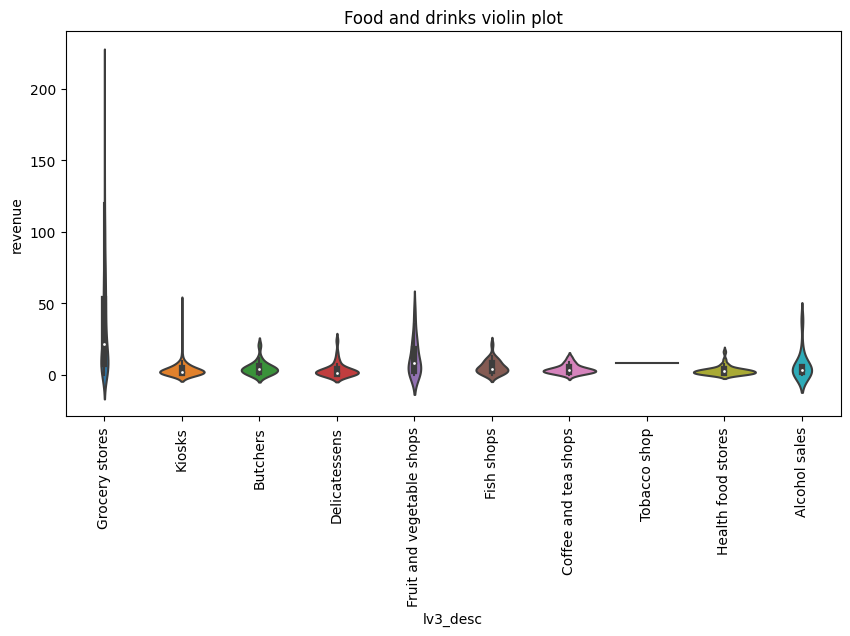

In [10]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Retailers with 0 revenue

In [12]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

,year,grunnkrets_id,lat,lon,revenue,lv1,lv2
count,217.0,2.170000e+02,217.000000,217.000000,217.0,217.000000,217.000000
mean,2016.0,7.609318e+06,60.671650,10.007769,0.0,1.788018,2.188940
std,0.0,5.511516e+06,2.432534,3.006842,0.0,0.594141,0.758634
min,2016.0,1.040301e+06,58.029041,5.035586,0.0,1.000000,1.100000
25%,2016.0,3.010401e+06,59.559941,8.591472,0.0,1.000000,1.100000
50%,2016.0,6.020802e+06,59.919065,10.620743,0.0,2.000000,2.400000
75%,2016.0,1.201012e+07,60.394286,10.814440,0.0,2.000000,2.800000
max,2016.0,2.030030e+07,69.890997,30.043801,0.0,3.000000,3.600000


all retailers and their cooresponding revenue, th plot is to distuingish outliers

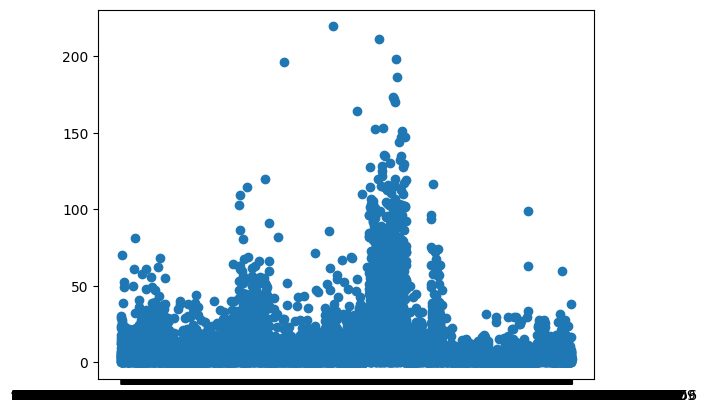

<Figure size 3000x500 with 0 Axes>

In [26]:
plt.plot(stores_train['store_id'], stores_train['revenue'],'o')
plt.figure(figsize=(30,5))
plt.show()

## Cleaning

Remove year

In [30]:
stores_train.drop(['year'], axis=1, inplace=True)
stores_train.head()

,store_id,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


Capping outliers

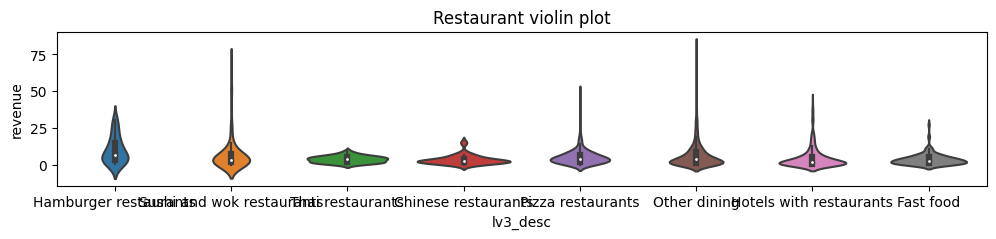

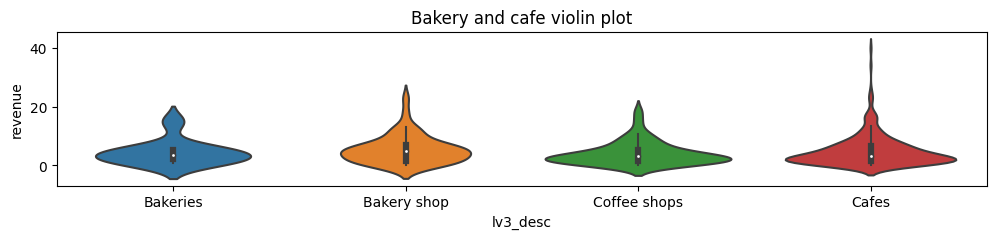

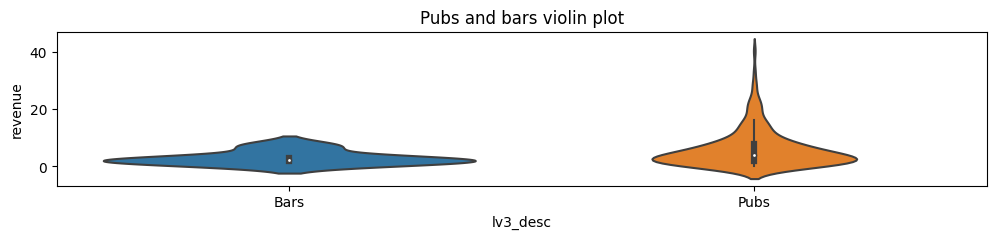

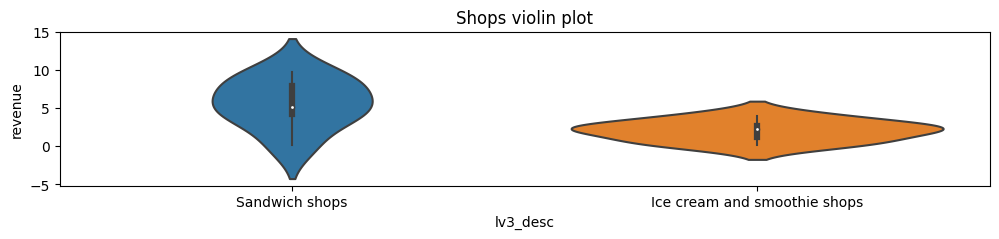

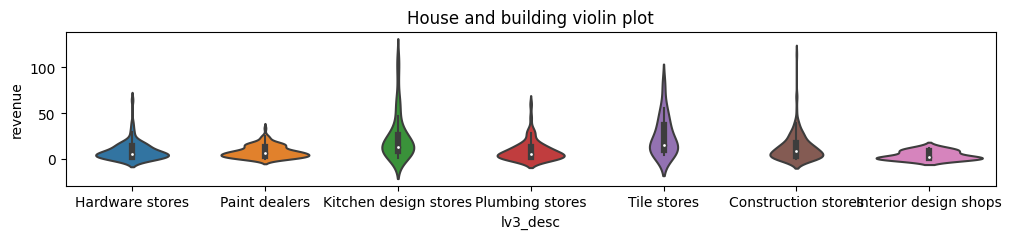

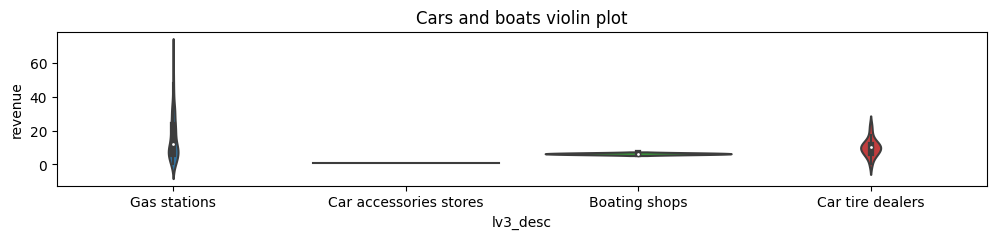

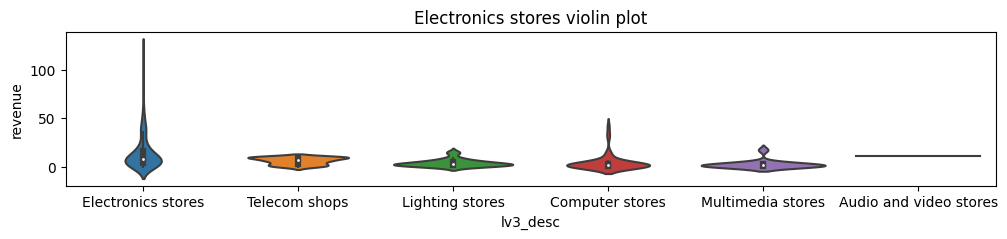

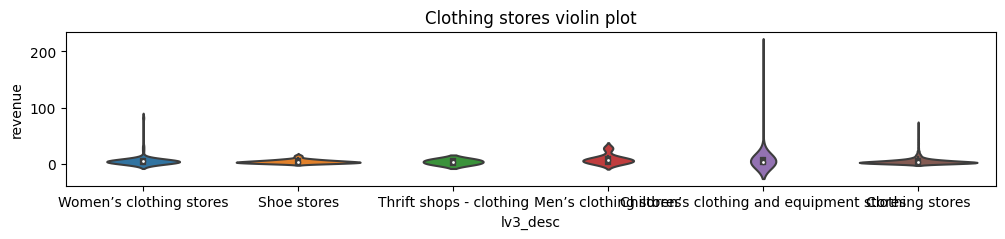

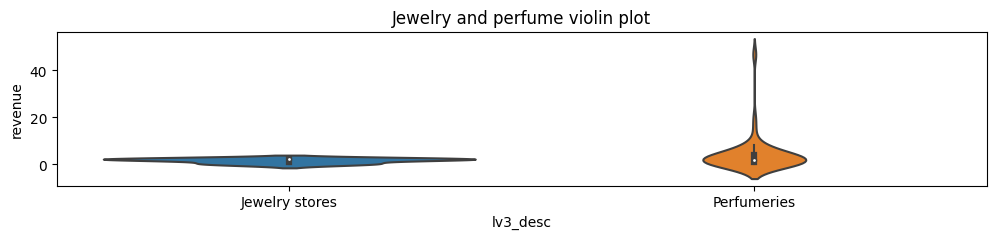

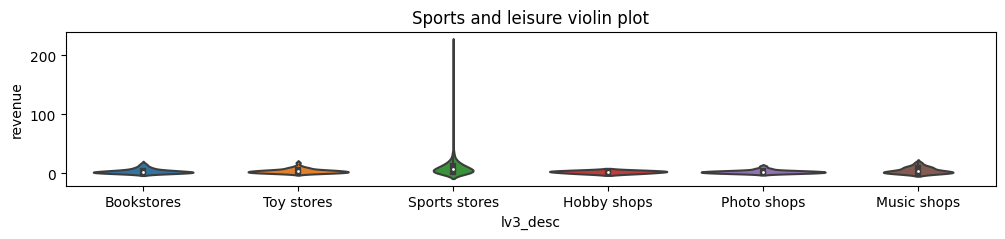

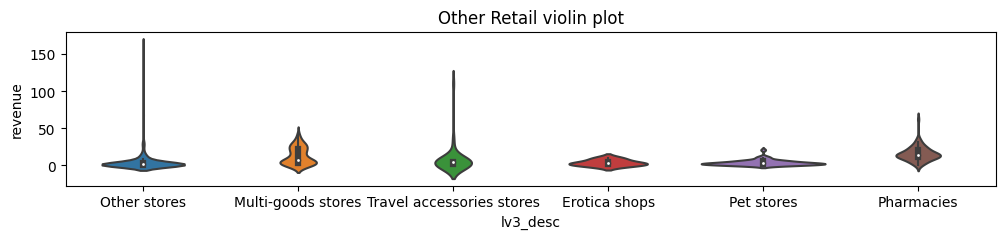

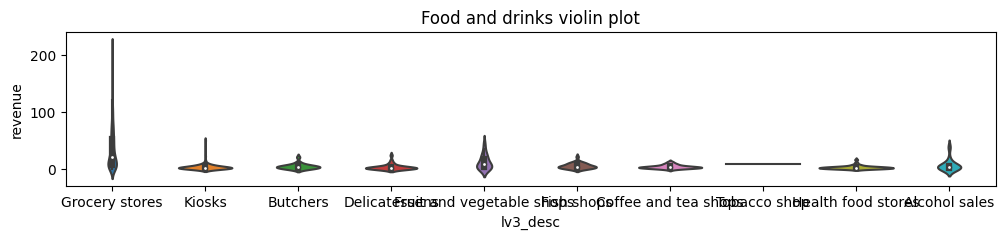

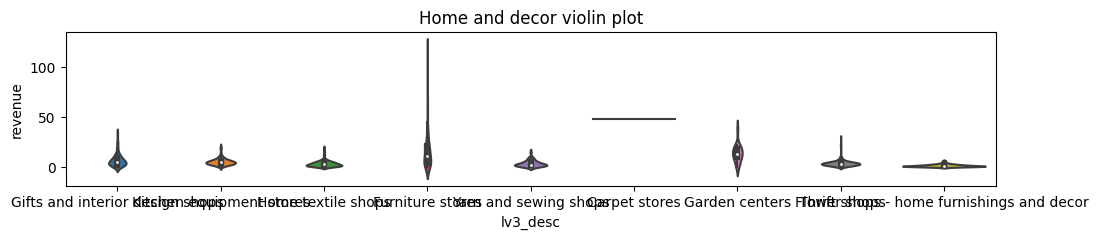

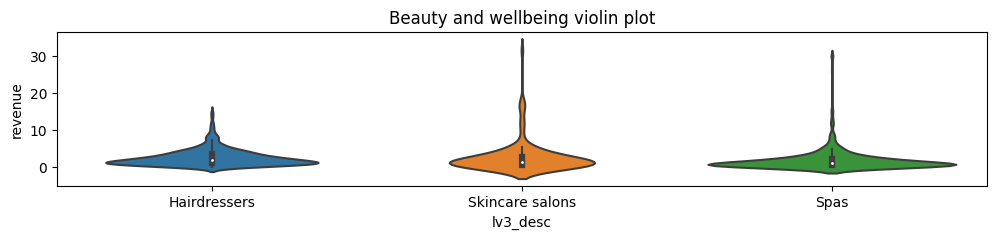

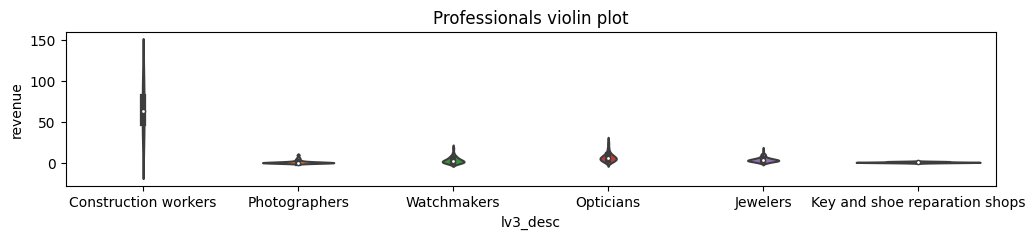

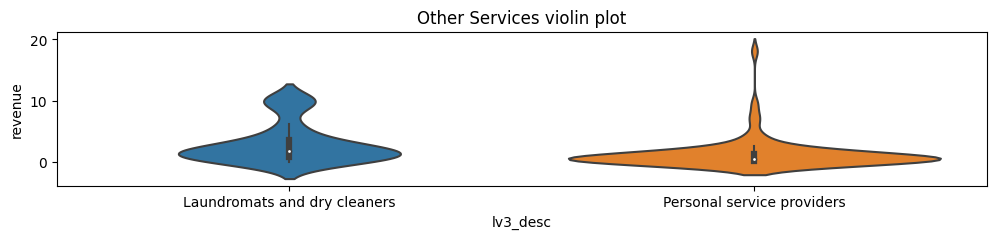

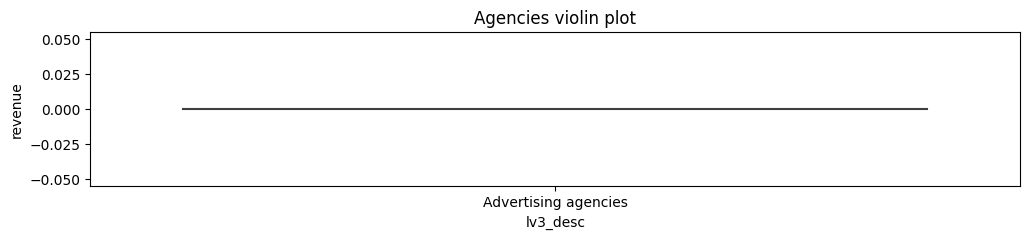

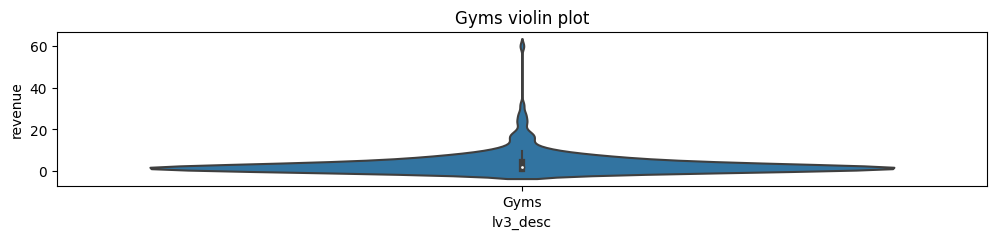

In [39]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

Plot after removing outliers


In [93]:
stores_train = pd.read_csv('data/stores_train.csv')

In [109]:
for store_type in stores_train['plaace_hierarchy_id'].unique():
    data = stores_train[stores_train['plaace_hierarchy_id']==store_type]
    upper_treshold = data['revenue'].quantile(0.95)
    lower_treshold = data['revenue'].quantile(0.05)
    #neww = stores_train[stores_train['plaace_hierarchy_id']==store_type].revenue < upper_treshold
    #stores_train.loc[(stores_train['plaace_hierarchy']==store_type) & (stores_train['revenue']>upper_treshold)]
    stores_train.drop(stores_train[(stores_train['plaace_hierarchy_id']==store_type) & (stores_train['revenue']>upper_treshold)].index, inplace=True)
    stores_train.drop(stores_train[(stores_train['plaace_hierarchy_id']==store_type) & (stores_train['revenue']<lower_treshold)].index, inplace=True)

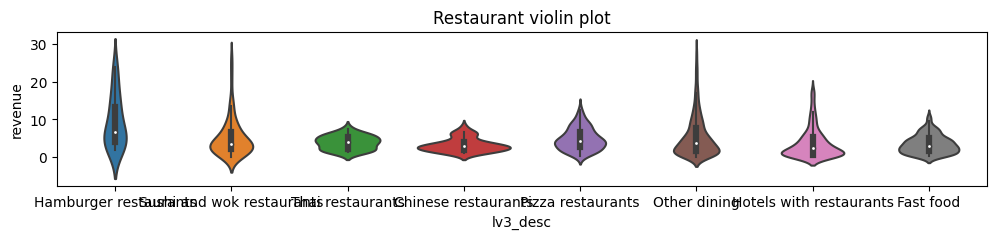

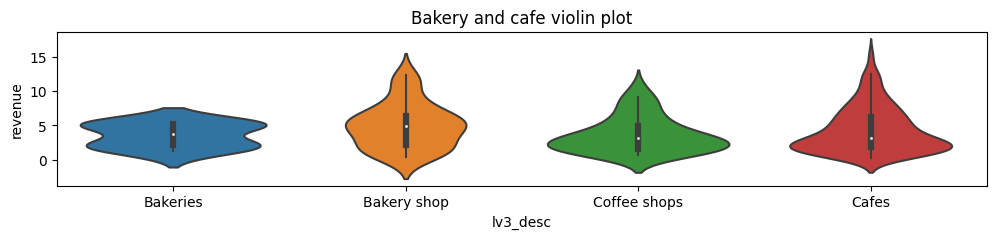

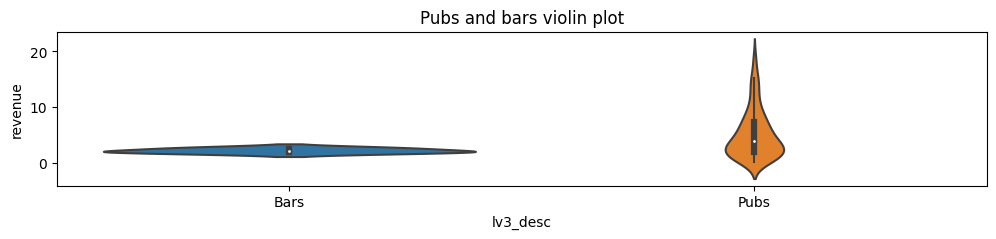

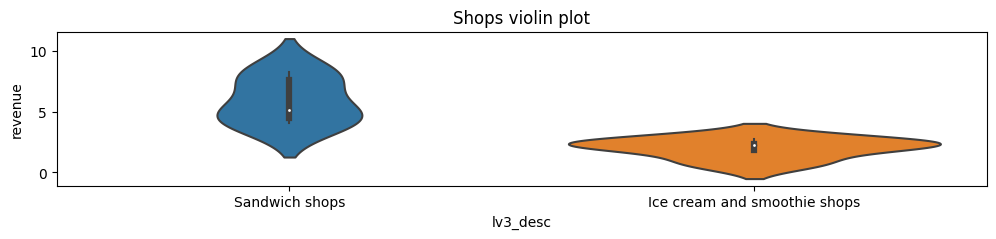

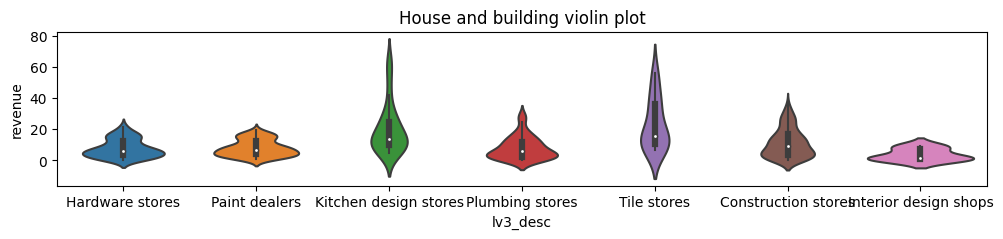

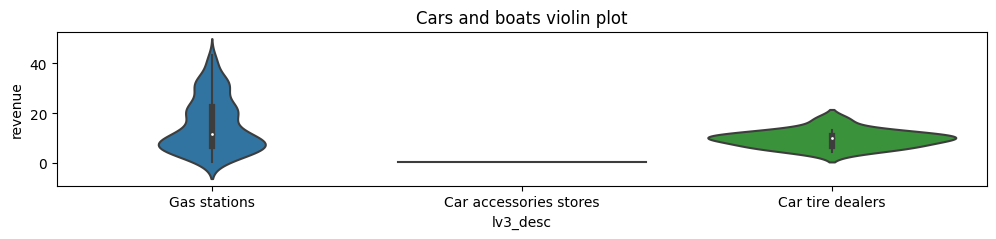

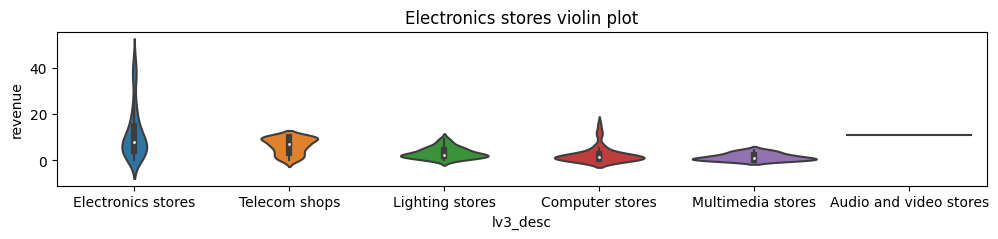

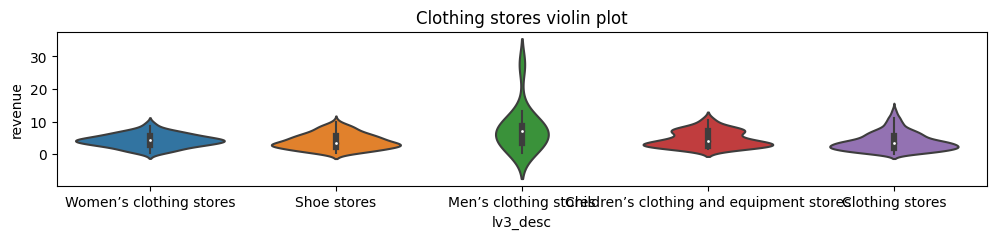

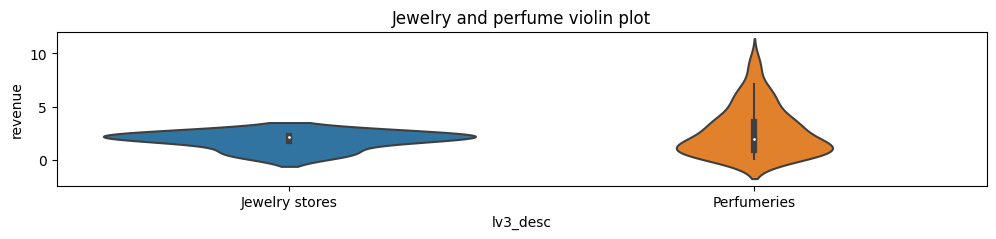

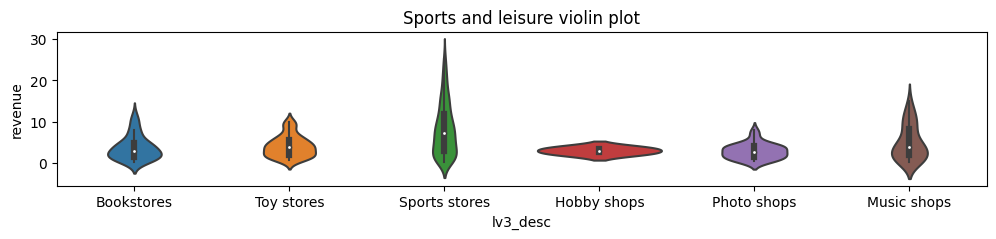

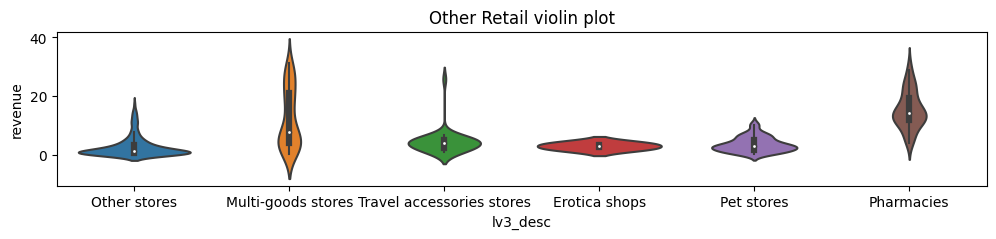

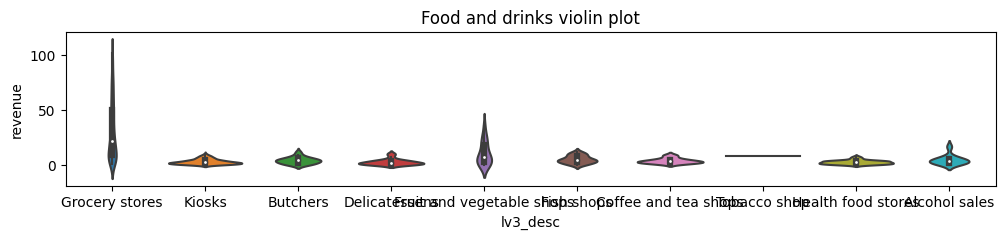

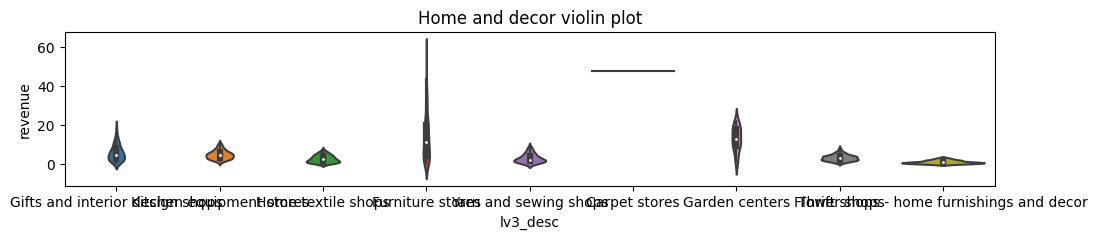

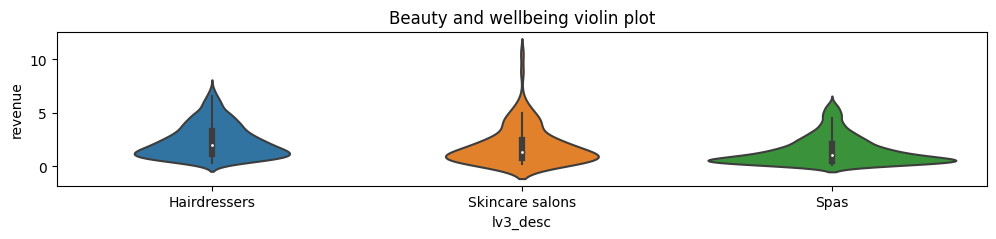

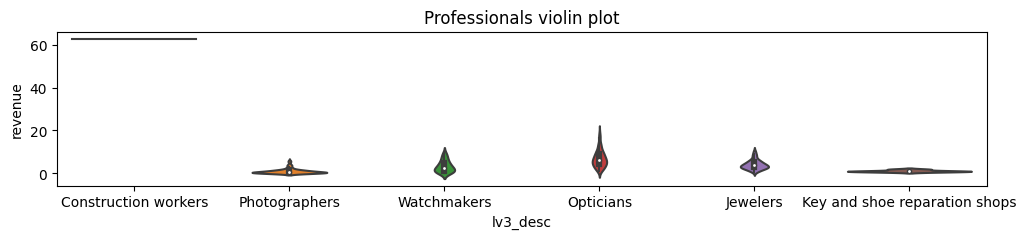

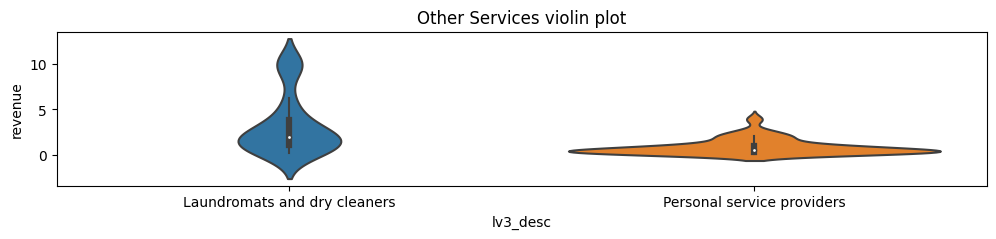

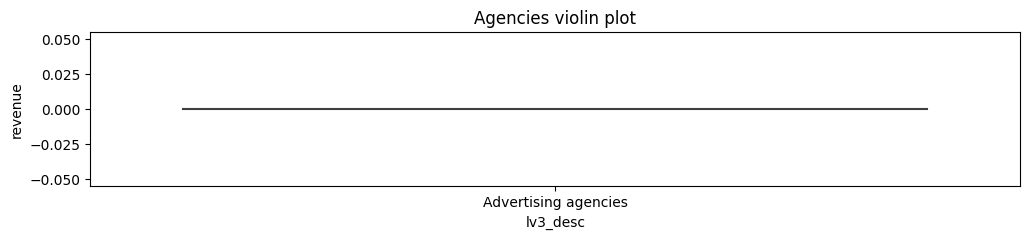

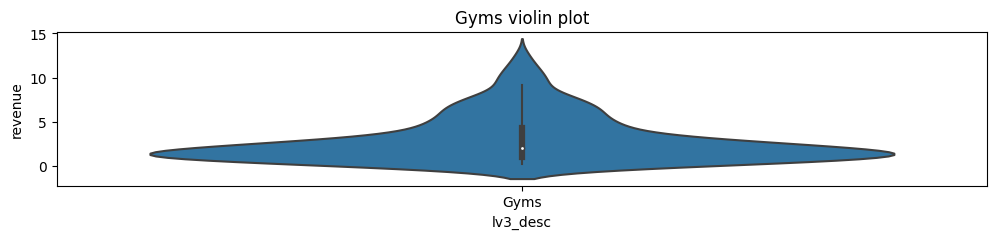

In [110]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

# 2. Machine Learning Model and Predictions
- [ ] at least two different models
- [ ] -

### Model 1

In [13]:
#Python stuff

# 3. Model Interpretations

### Lime

In [14]:
#lime stuff in python

### Feature importance

In [15]:
#feature importance

### PDP

In [16]:
#PDP

# 4. Feature Engineering

### some feature moding

In [17]:
#modding data....

# 5. Final improved models/predictions

### model 1

In [18]:
#final model 1

### model 2

In [19]:
#final model 2

# Testing


### RMSLE